In [43]:
!pip install transformers nltk keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [45]:
import os
import re
import sys
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [46]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import itertools
from joblib import dump, load
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [47]:
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, SpatialDropout1D, Embedding

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud

In [50]:
df = pd.read_csv('ResumeDataSet.csv')
df.shape

(962, 2)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [52]:
df.isna().sum()

Category    0
Resume      0
dtype: int64

In [53]:
print("Total number of available jobs:", df.Category.nunique())

Total number of available jobs: 25


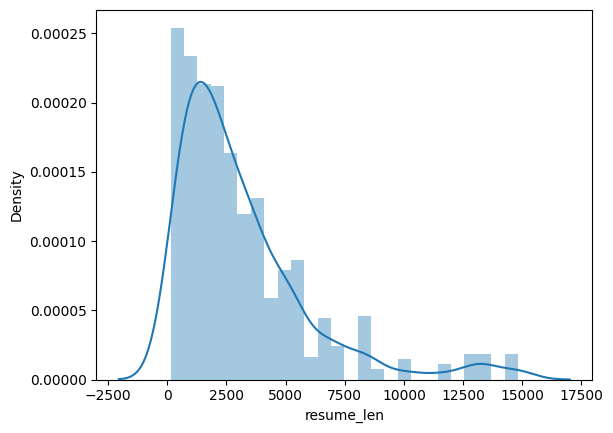

In [54]:
df['resume_len'] = df.Resume.apply(len)
sns.distplot(df.resume_len);

In [55]:
df.describe()

,resume_len
count,962.000000
mean,3160.364865
std,2886.528521
min,142.000000
25%,1217.250000
50%,2355.000000
75%,4073.750000
max,14816.000000


In [56]:
max_resume_len = 512

# Converting the data into lower case and removing words with small lengths

In [57]:
df['Resume'] = df['Resume'].apply(lambda x:x.lower())
for i in range(len(df)):
    lw=[]
    for j in df['Resume'][i].split():
        if len(j)>=3:                  
            lw.append(j)
    df['Resume'][i]=" ".join(lw)

# Removing punctuations

In [58]:
ps = list(";?.:!,")
df['Resume'] = df['Resume']

for p in ps:   
    df['Resume'] = df['Resume'].str.replace(p, '')

# Removing '\n' and '\t', extra spaces, quoting text and progressive pronouns

In [59]:
df['Resume'] = df['Resume'].str.replace("    ", " ")
df['Resume'] = df['Resume'].str.replace('"', '')
df['Resume'] = df['Resume'].apply(lambda x: x.replace('\t', ' '))
df['Resume'] = df['Resume'].str.replace("'s", "")
df['Resume'] = df['Resume'].apply(lambda x: x.replace('\n', ' '))

# Applying Lemmatization

In [60]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [61]:
wl = WordNetLemmatizer()
nr = len(df)
lis = []
for r in range(0, nr):
    ll = []
    t = df.loc[r]['Resume']
    tw = str(t).split(" ")
    for w in tw:
        ll.append(wl.lemmatize(w, pos="v"))
    lt = " ".join(ll)
    lis.append(lt)

In [62]:
df['Resume'] = lis

# Removing Stop-words

In [63]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
sw = list(stopwords.words('english'))
for s in sw:
    rs = r"\b" + s + r"\b"
    df['Resume'] = df['Resume'].str.replace(rs, '')

In [65]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

labels_dict

{'Data Science': 0,
 'HR': 1,
 'Advocate': 2,
 'Arts': 3,
 'Web Designing': 4,
 'Mechanical Engineer': 5,
 'Sales': 6,
 'Health and fitness': 7,
 'Civil Engineer': 8,
 'Java Developer': 9,
 'Business Analyst': 10,
 'SAP Developer': 11,
 'Automation Testing': 12,
 'Electrical Engineering': 13,
 'Operations Manager': 14,
 'Python Developer': 15,
 'DevOps Engineer': 16,
 'Network Security Engineer': 17,
 'PMO': 18,
 'Database': 19,
 'Hadoop': 20,
 'ETL Developer': 21,
 'DotNet Developer': 22,
 'Blockchain': 23,
 'Testing': 24}

In [66]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

In [67]:
tokenizer = AutoTokenizer.from_pretrained("manishiitg/distilbert-resume-parts-classify")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("manishiitg/distilbert-resume-parts-classify",from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [68]:
preprocessed_df = df

In [69]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.1,shuffle=True,random_state=101)

In [70]:
X_train = tokenizer(text=train_df.Resume.tolist(),
                   add_special_tokens=True,
                   padding=True,
                   truncation=True,
                   max_length=max_resume_len,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.Resume.tolist(),
                  add_special_tokens=True,
                  padding=True,
                  truncation=True,
                  max_length=max_resume_len,
                  return_tensors='tf',
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=1)

In [71]:
input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

In [72]:
word_embeddings = bert_model(input_ids,attention_mask=attention_masks)[0] # 0 --> final hidden state, 1 --> pooling output


output = Flatten()(word_embeddings)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=25,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_masks],outputs=output)
model.layers

In [73]:
model.layers[2].trainable = True

In [74]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66962700   ['input_ids[0][0]',              
 assification_1 (TFDistilBertFo  rOutput(loss=None,               'attention_mask[0][0]']         
 rSequenceClassification)       logits=(None, 12),                                                
                                 hidden_states=None                                         

In [75]:
"""
adam = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           decay=0.01,
           clipnorm=1.0)
"""
import tensorflow as tf
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
adam = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,
           epsilon=2e-8,
           decay=0.01,
           clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=SparseCategoricalAccuracy('balanced_accuracy'))

In [77]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=250,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint('resume_parser.h5',monitor='val_balanced_accuracy',mode='max',verbose=1,save_best_only=True)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.Category,
             epochs=75,
             batch_size=16,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category))

Epoch 1/75
55/55 [==============================] - ETA: 0s - loss: 3.5452 - balanced_accuracy: 0.0428
Epoch 1: val_balanced_accuracy improved from -inf to 0.05155, saving model to resume_parser.h5
55/55 [==============================] - 60s 1s/step - loss: 3.5452 - balanced_accuracy: 0.0428 - val_loss: 3.2219 - val_balanced_accuracy: 0.0515
Epoch 2/75
55/55 [==============================] - ETA: 0s - loss: 3.4488 - balanced_accuracy: 0.0532
Epoch 2: val_balanced_accuracy did not improve from 0.05155
55/55 [==============================] - 53s 970ms/step - loss: 3.4488 - balanced_accuracy: 0.0532 - val_loss: 3.2193 - val_balanced_accuracy: 0.0412
Epoch 3/75
55/55 [==============================] - ETA: 0s - loss: 3.3514 - balanced_accuracy: 0.0590
Epoch 3: val_balanced_accuracy did not improve from 0.05155
55/55 [==============================] - 53s 959ms/step - loss: 3.3514 - balanced_accuracy: 0.0590 - val_loss: 3.1981 - val_balanced_accuracy: 0.0515
Epoch 4/75
55/55 [===========

In [78]:
score, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category)
print("Test Accuracy:", acc)

4/4 [==============================] - 2s 454ms/step - loss: 1.2441 - balanced_accuracy: 0.6701
Test Accuracy: 0.6701030731201172


In [79]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
test_predictions

4/4 [==============================] - 4s 464ms/step


array([ 1, 14,  9, 15,  1, 14, 24, 21,  1, 15, 18,  5, 24, 24, 14,  7,  1,
       17, 23, 14,  5, 17,  9, 13, 14, 20,  4,  9, 20,  9, 20,  4,  4, 21,
        6,  5,  9, 23, 13, 24, 14, 24, 20,  9,  9, 18, 14, 21, 23, 20, 14,
       20, 14, 13,  1, 24,  6, 23, 16,  6, 13, 21, 14, 23, 24, 15, 16,  5,
       16, 22, 14,  9,  6, 21, 23,  1, 23,  1, 15, 18, 24, 19, 20,  1,  4,
        1,  1, 20, 14, 24,  9, 21, 15, 15,  3, 20, 20])

In [80]:
print('Accuracy:', accuracy_score(test_predictions,test_df.Category))
print('Precision:', precision_score(test_predictions,test_df.Category, average='weighted'))
print('Recall:', recall_score(test_predictions,test_df.Category, average='weighted'))
print('F1 score:', f1_score(test_predictions,test_df.Category, average='micro'))

Accuracy: 0.6701030927835051
Precision: 0.9224349533627885
Recall: 0.6701030927835051
F1 score: 0.6701030927835051
